# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

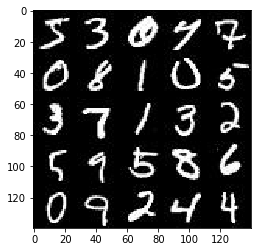

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

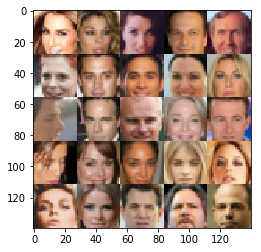

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/jon/anaconda/envs/tea-py3/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [21]:
def lrelu(x, leak=0.2, name="lrelu"):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x)

def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        print("D_in.shape:", images.shape)
        ## Layer 1
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding="same",
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        # Leak Relu
        x1 = lrelu(x1)
        print("D_x1.shape:", x1.shape)
        # 14x14x64
        
        ## Layer 2
        x2 = tf.layers.conv2d(inputs=x1, filters=128, kernel_size=5, strides=2, padding="same",
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        # Batch Normalize
        x2 = tf.layers.batch_normalization(x2, training=True)
        # Leak Relu
        x2 = lrelu(x2)
        print("D_x2.shape:", x2.shape)
        # 7x7x128
        
        ## Layer 3 
        x3 = tf.layers.conv2d(inputs=x2, filters=256, kernel_size=5, strides=1, padding="same",
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        # Batch Normalize
        x3 = tf.layers.batch_normalization(x3, training=True)
        # Leak Relu
        x3 = lrelu(x3)
        print("D_x3.shape:", x3.shape)
        # 5x5x256
        
        # Fully connected layer
        x3 = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(inputs=x3, units=1, activation=None)
        out = tf.sigmoid(logits)
        print("D_out.shape:", out.shape)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

D_in.shape: (?, 28, 28, 3)
D_x1.shape: (?, 14, 14, 64)
D_x2.shape: (?, 7, 7, 128)
D_x3.shape: (?, 7, 7, 256)
D_out.shape: (?, 1)
D_in.shape: (?, 28, 28, 3)
D_x1.shape: (?, 14, 14, 64)
D_x2.shape: (?, 7, 7, 128)
D_x3.shape: (?, 7, 7, 256)
D_out.shape: (?, 1)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope("generator", reuse=not is_train):
        print("G_in.shape:", z.shape)
        ## Layer 1
        # First fully connected layer
        x1 = tf.layers.dense(inputs=z, units=7*7*256, activation=None)
        x1 = tf.reshape(x1,(-1,7,7,256))
        # Batch Normalize
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # Leak Relu
        x1 = lrelu(x1)
        print("G_x1.shape:", x1.shape)
        
        ## Layer 2
        x2 = tf.layers.conv2d_transpose(inputs=x1, filters=128, kernel_size=5, strides=1, padding="same", 
                                        kernel_initializer = tf.contrib.layers.xavier_initializer())
        # Batch Normalize
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        # Leak Relu
        x2 = lrelu(x2)
        print("G_x2.shape:", x2.shape)
        
        ## Layer 3
        x3 = tf.layers.conv2d_transpose(inputs=x2, filters=64, kernel_size=5, strides=2, padding="same", 
                                        kernel_initializer = tf.contrib.layers.xavier_initializer())
        # Batch Normalize
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        # Leak Relu
        x3 = tf.maximum(alpha*x3, x3)
        print("G_x3.shape:", x3.shape)
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(inputs=x3, filters=out_channel_dim, kernel_size=5, strides=2, padding="same", 
                                            kernel_initializer = tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        print("G_out.shape:", out.shape)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 5)
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)* np.random.uniform(0.7, 1.2)))
    # d_loss_real = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 4)
D_in.shape: (?, 28, 28, 4)
D_x1.shape: (?, 14, 14, 64)
D_x2.shape: (?, 7, 7, 128)
D_x3.shape: (?, 7, 7, 256)
D_out.shape: (?, 1)
D_in.shape: (?, 28, 28, 4)
D_x1.shape: (?, 14, 14, 64)
D_x2.shape: (?, 7, 7, 128)
D_x3.shape: (?, 7, 7, 256)
D_out.shape: (?, 1)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Build network
    data_count = data_shape[0]
    real_size = data_shape[1:]
    image_width = real_size[0]
    image_height = real_size[1]
    image_channels = real_size[2]
        
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every=20
    show_every=100
    samples, losses = [], []
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            # Batch number
            b = 0
            for batch_images in get_batches(batch_size):
                b += 1
                
                # Normalize input from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                                   input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                                   input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                                   input_z: batch_z, lr: learning_rate})
                
                # Print batch loss
                if b % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    batches = int(data_count/batch_size)
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Batch {}/{}...".format(b+1, batches),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # Show image
                if b % show_every == 0:
                    show_generator_output(sess, 20, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
          

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1) L
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)
D_in.shape: (?, 28, 28, 1)
D_x1.shape: (?, 14, 14, 64)
D_x2.shape: (?, 7, 7, 128)
D_x3.shape: (?, 7, 7, 256)
D_out.shape: (?, 1)
D_in.shape: (?, 28, 28, 1)
D_x1.shape: (?, 14, 14, 64)
D_x2.shape: (?, 7, 7, 128)
D_x3.shape: (?, 7, 7, 256)
D_out.shape: (?, 1)
Epoch 1/2... Batch 21/937... Discriminator Loss: 1.4741... Generator Loss: 4.9836
Epoch 1/2... Batch 41/937... Discriminator Loss: 1.3419... Generator Loss: 1.4741
Epoch 1/2... Batch 61/937... Discriminator Loss: 1.1686... Generator Loss: 1.1752
Epoch 1/2... Batch 81/937... Discriminator Loss: 1.1244... Generator Loss: 1.3887
Epoch 1/2... Batch 101/937... Discriminator Loss: 1.0110... Generator Loss: 0.8872
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


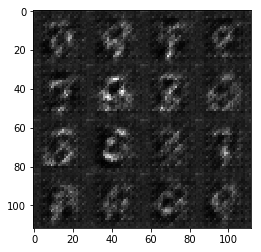

Epoch 1/2... Batch 121/937... Discriminator Loss: 1.0925... Generator Loss: 1.5530
Epoch 1/2... Batch 141/937... Discriminator Loss: 1.2887... Generator Loss: 1.9379
Epoch 1/2... Batch 161/937... Discriminator Loss: 1.1173... Generator Loss: 0.9027
Epoch 1/2... Batch 181/937... Discriminator Loss: 1.0921... Generator Loss: 1.6152
Epoch 1/2... Batch 201/937... Discriminator Loss: 1.0568... Generator Loss: 1.8376
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


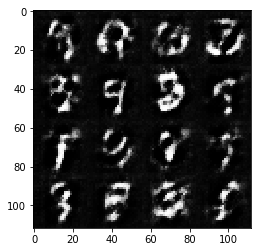

Epoch 1/2... Batch 221/937... Discriminator Loss: 0.9109... Generator Loss: 1.4168
Epoch 1/2... Batch 241/937... Discriminator Loss: 0.9575... Generator Loss: 1.0644
Epoch 1/2... Batch 261/937... Discriminator Loss: 1.4797... Generator Loss: 2.5877
Epoch 1/2... Batch 281/937... Discriminator Loss: 1.1234... Generator Loss: 1.3514
Epoch 1/2... Batch 301/937... Discriminator Loss: 0.9624... Generator Loss: 1.0306
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


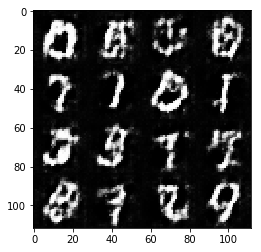

Epoch 1/2... Batch 321/937... Discriminator Loss: 1.0756... Generator Loss: 1.2364
Epoch 1/2... Batch 341/937... Discriminator Loss: 1.2309... Generator Loss: 0.5757
Epoch 1/2... Batch 361/937... Discriminator Loss: 0.9772... Generator Loss: 1.2116
Epoch 1/2... Batch 381/937... Discriminator Loss: 0.8148... Generator Loss: 1.5979
Epoch 1/2... Batch 401/937... Discriminator Loss: 1.1691... Generator Loss: 0.7926
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


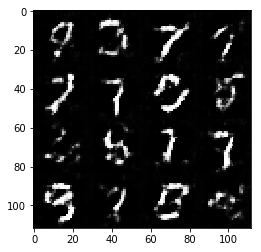

Epoch 1/2... Batch 421/937... Discriminator Loss: 1.1574... Generator Loss: 1.8244
Epoch 1/2... Batch 441/937... Discriminator Loss: 1.3389... Generator Loss: 0.4710
Epoch 1/2... Batch 461/937... Discriminator Loss: 1.2046... Generator Loss: 0.6486
Epoch 1/2... Batch 481/937... Discriminator Loss: 1.0140... Generator Loss: 1.0355
Epoch 1/2... Batch 501/937... Discriminator Loss: 1.0256... Generator Loss: 1.0827
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


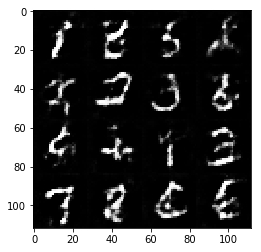

Epoch 1/2... Batch 521/937... Discriminator Loss: 1.2517... Generator Loss: 0.7132
Epoch 1/2... Batch 541/937... Discriminator Loss: 1.0557... Generator Loss: 1.0231
Epoch 1/2... Batch 561/937... Discriminator Loss: 1.1895... Generator Loss: 1.5215
Epoch 1/2... Batch 581/937... Discriminator Loss: 1.0867... Generator Loss: 1.1438
Epoch 1/2... Batch 601/937... Discriminator Loss: 1.0946... Generator Loss: 1.3103
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


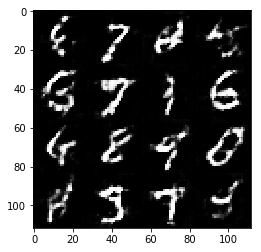

Epoch 1/2... Batch 621/937... Discriminator Loss: 1.1050... Generator Loss: 1.2526
Epoch 1/2... Batch 641/937... Discriminator Loss: 1.0855... Generator Loss: 0.9419
Epoch 1/2... Batch 661/937... Discriminator Loss: 1.0890... Generator Loss: 0.9548
Epoch 1/2... Batch 681/937... Discriminator Loss: 1.1816... Generator Loss: 0.7635
Epoch 1/2... Batch 701/937... Discriminator Loss: 1.1202... Generator Loss: 0.9583
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


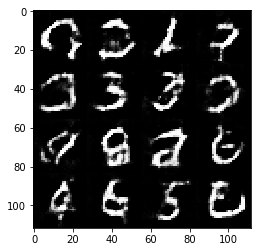

Epoch 1/2... Batch 721/937... Discriminator Loss: 1.1661... Generator Loss: 0.9178
Epoch 1/2... Batch 741/937... Discriminator Loss: 1.0259... Generator Loss: 1.2655
Epoch 1/2... Batch 761/937... Discriminator Loss: 0.9800... Generator Loss: 1.0140
Epoch 1/2... Batch 781/937... Discriminator Loss: 1.2607... Generator Loss: 0.6206
Epoch 1/2... Batch 801/937... Discriminator Loss: 1.1180... Generator Loss: 1.1679
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


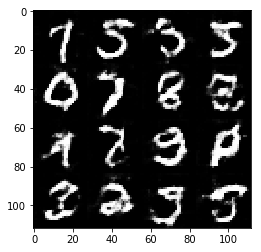

Epoch 1/2... Batch 821/937... Discriminator Loss: 1.0990... Generator Loss: 1.5952
Epoch 1/2... Batch 841/937... Discriminator Loss: 1.0493... Generator Loss: 0.7891
Epoch 1/2... Batch 861/937... Discriminator Loss: 1.9820... Generator Loss: 0.4282
Epoch 1/2... Batch 881/937... Discriminator Loss: 0.9563... Generator Loss: 1.3639
Epoch 1/2... Batch 901/937... Discriminator Loss: 0.9700... Generator Loss: 1.2316
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


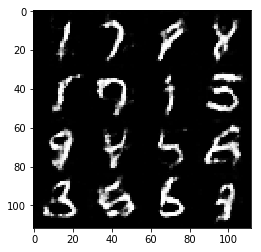

Epoch 1/2... Batch 921/937... Discriminator Loss: 1.1465... Generator Loss: 1.2054
Epoch 2/2... Batch 21/937... Discriminator Loss: 1.0891... Generator Loss: 0.7850
Epoch 2/2... Batch 41/937... Discriminator Loss: 1.1288... Generator Loss: 1.1774
Epoch 2/2... Batch 61/937... Discriminator Loss: 1.2734... Generator Loss: 0.6326
Epoch 2/2... Batch 81/937... Discriminator Loss: 1.2143... Generator Loss: 0.7591
Epoch 2/2... Batch 101/937... Discriminator Loss: 1.1205... Generator Loss: 0.7786
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


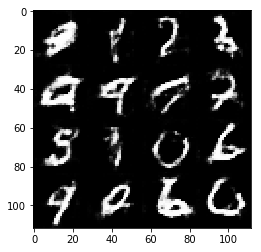

Epoch 2/2... Batch 121/937... Discriminator Loss: 1.0202... Generator Loss: 1.5220
Epoch 2/2... Batch 141/937... Discriminator Loss: 1.0619... Generator Loss: 1.0689
Epoch 2/2... Batch 161/937... Discriminator Loss: 1.1047... Generator Loss: 1.0554
Epoch 2/2... Batch 181/937... Discriminator Loss: 1.0786... Generator Loss: 1.0580
Epoch 2/2... Batch 201/937... Discriminator Loss: 1.0763... Generator Loss: 1.4858
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


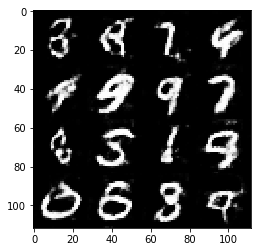

Epoch 2/2... Batch 221/937... Discriminator Loss: 1.0683... Generator Loss: 1.1320
Epoch 2/2... Batch 241/937... Discriminator Loss: 1.1919... Generator Loss: 0.7098
Epoch 2/2... Batch 261/937... Discriminator Loss: 1.1254... Generator Loss: 1.8967
Epoch 2/2... Batch 281/937... Discriminator Loss: 1.2013... Generator Loss: 0.9732
Epoch 2/2... Batch 301/937... Discriminator Loss: 1.2754... Generator Loss: 0.6002
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


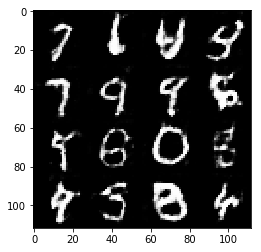

Epoch 2/2... Batch 321/937... Discriminator Loss: 1.2172... Generator Loss: 0.8051
Epoch 2/2... Batch 341/937... Discriminator Loss: 0.9377... Generator Loss: 1.3640
Epoch 2/2... Batch 361/937... Discriminator Loss: 1.0117... Generator Loss: 1.1211
Epoch 2/2... Batch 381/937... Discriminator Loss: 0.9594... Generator Loss: 0.9858
Epoch 2/2... Batch 401/937... Discriminator Loss: 1.1476... Generator Loss: 0.9992
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


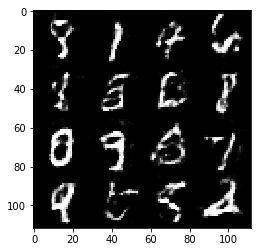

Epoch 2/2... Batch 421/937... Discriminator Loss: 0.9823... Generator Loss: 1.0398
Epoch 2/2... Batch 441/937... Discriminator Loss: 1.0832... Generator Loss: 0.7531
Epoch 2/2... Batch 461/937... Discriminator Loss: 1.2345... Generator Loss: 0.5981
Epoch 2/2... Batch 481/937... Discriminator Loss: 1.1071... Generator Loss: 0.9275
Epoch 2/2... Batch 501/937... Discriminator Loss: 1.0959... Generator Loss: 1.1860
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


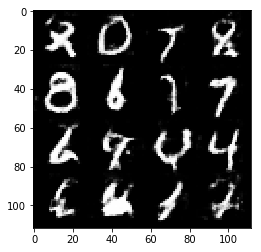

Epoch 2/2... Batch 521/937... Discriminator Loss: 1.0378... Generator Loss: 1.1840
Epoch 2/2... Batch 541/937... Discriminator Loss: 1.0725... Generator Loss: 1.2019
Epoch 2/2... Batch 561/937... Discriminator Loss: 1.1175... Generator Loss: 0.8397
Epoch 2/2... Batch 581/937... Discriminator Loss: 1.0254... Generator Loss: 0.8475
Epoch 2/2... Batch 601/937... Discriminator Loss: 1.0181... Generator Loss: 1.1654
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


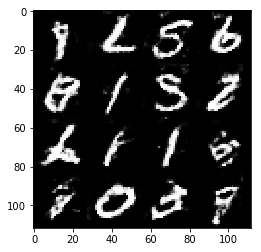

Epoch 2/2... Batch 621/937... Discriminator Loss: 1.0329... Generator Loss: 1.2791
Epoch 2/2... Batch 641/937... Discriminator Loss: 1.1462... Generator Loss: 1.4131
Epoch 2/2... Batch 661/937... Discriminator Loss: 1.4425... Generator Loss: 0.4555
Epoch 2/2... Batch 681/937... Discriminator Loss: 1.0908... Generator Loss: 0.7859
Epoch 2/2... Batch 701/937... Discriminator Loss: 1.1835... Generator Loss: 1.4324
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


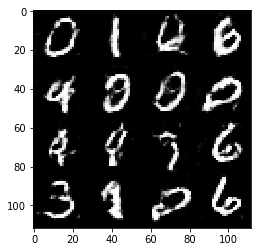

Epoch 2/2... Batch 721/937... Discriminator Loss: 1.1576... Generator Loss: 0.8561
Epoch 2/2... Batch 741/937... Discriminator Loss: 1.0310... Generator Loss: 1.4152
Epoch 2/2... Batch 761/937... Discriminator Loss: 1.0107... Generator Loss: 0.9446
Epoch 2/2... Batch 781/937... Discriminator Loss: 1.1161... Generator Loss: 1.1226
Epoch 2/2... Batch 801/937... Discriminator Loss: 1.4525... Generator Loss: 1.9981
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


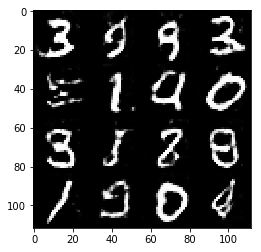

Epoch 2/2... Batch 821/937... Discriminator Loss: 1.0333... Generator Loss: 1.4642
Epoch 2/2... Batch 841/937... Discriminator Loss: 0.9026... Generator Loss: 1.4710
Epoch 2/2... Batch 861/937... Discriminator Loss: 2.1387... Generator Loss: 0.2334
Epoch 2/2... Batch 881/937... Discriminator Loss: 1.0210... Generator Loss: 1.4953
Epoch 2/2... Batch 901/937... Discriminator Loss: 1.0240... Generator Loss: 1.1994
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 1)


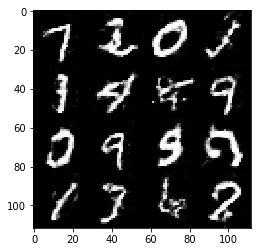

Epoch 2/2... Batch 921/937... Discriminator Loss: 1.0901... Generator Loss: 1.4186


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape, mnist_dataset.image_mode)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)
D_in.shape: (?, 28, 28, 3)
D_x1.shape: (?, 14, 14, 64)
D_x2.shape: (?, 7, 7, 128)
D_x3.shape: (?, 7, 7, 256)
D_out.shape: (?, 1)
D_in.shape: (?, 28, 28, 3)
D_x1.shape: (?, 14, 14, 64)
D_x2.shape: (?, 7, 7, 128)
D_x3.shape: (?, 7, 7, 256)
D_out.shape: (?, 1)
Epoch 1/1... Batch 21/3165... Discriminator Loss: 1.0967... Generator Loss: 4.8015
Epoch 1/1... Batch 41/3165... Discriminator Loss: 1.5777... Generator Loss: 4.7443
Epoch 1/1... Batch 61/3165... Discriminator Loss: 1.2724... Generator Loss: 2.4624
Epoch 1/1... Batch 81/3165... Discriminator Loss: 1.1305... Generator Loss: 1.8635
Epoch 1/1... Batch 101/3165... Discriminator Loss: 1.1927... Generator Loss: 1.5101
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


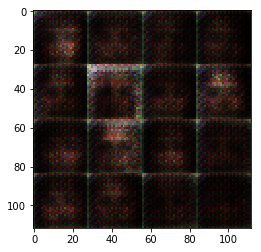

Epoch 1/1... Batch 121/3165... Discriminator Loss: 1.2151... Generator Loss: 1.4727
Epoch 1/1... Batch 141/3165... Discriminator Loss: 1.2203... Generator Loss: 1.1857
Epoch 1/1... Batch 161/3165... Discriminator Loss: 1.3361... Generator Loss: 1.8560
Epoch 1/1... Batch 181/3165... Discriminator Loss: 1.2325... Generator Loss: 1.2901
Epoch 1/1... Batch 201/3165... Discriminator Loss: 1.2932... Generator Loss: 1.2050
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


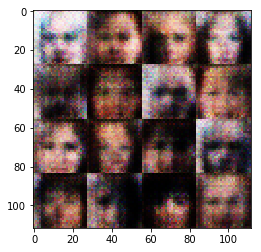

Epoch 1/1... Batch 221/3165... Discriminator Loss: 1.1932... Generator Loss: 1.3394
Epoch 1/1... Batch 241/3165... Discriminator Loss: 1.3152... Generator Loss: 0.8715
Epoch 1/1... Batch 261/3165... Discriminator Loss: 1.2616... Generator Loss: 0.9734
Epoch 1/1... Batch 281/3165... Discriminator Loss: 1.4413... Generator Loss: 0.9592
Epoch 1/1... Batch 301/3165... Discriminator Loss: 1.3167... Generator Loss: 1.4401
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


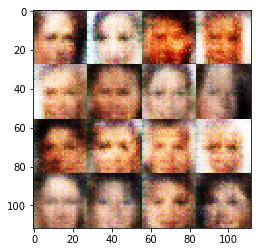

Epoch 1/1... Batch 321/3165... Discriminator Loss: 1.2425... Generator Loss: 1.2797
Epoch 1/1... Batch 341/3165... Discriminator Loss: 1.3893... Generator Loss: 0.8441
Epoch 1/1... Batch 361/3165... Discriminator Loss: 1.2989... Generator Loss: 0.9830
Epoch 1/1... Batch 381/3165... Discriminator Loss: 1.3001... Generator Loss: 1.0091
Epoch 1/1... Batch 401/3165... Discriminator Loss: 1.3307... Generator Loss: 1.1623
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


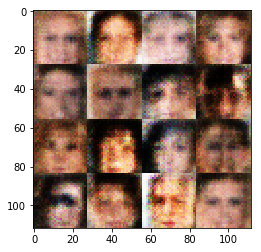

Epoch 1/1... Batch 421/3165... Discriminator Loss: 1.3642... Generator Loss: 1.0107
Epoch 1/1... Batch 441/3165... Discriminator Loss: 1.3652... Generator Loss: 0.9335
Epoch 1/1... Batch 461/3165... Discriminator Loss: 1.2990... Generator Loss: 0.9462
Epoch 1/1... Batch 481/3165... Discriminator Loss: 1.3514... Generator Loss: 1.0635
Epoch 1/1... Batch 501/3165... Discriminator Loss: 1.3212... Generator Loss: 1.0264
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


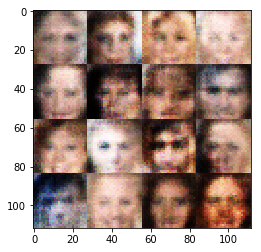

Epoch 1/1... Batch 521/3165... Discriminator Loss: 1.3440... Generator Loss: 0.9279
Epoch 1/1... Batch 541/3165... Discriminator Loss: 1.3709... Generator Loss: 0.9193
Epoch 1/1... Batch 561/3165... Discriminator Loss: 1.3292... Generator Loss: 0.9724
Epoch 1/1... Batch 581/3165... Discriminator Loss: 1.3601... Generator Loss: 0.8710
Epoch 1/1... Batch 601/3165... Discriminator Loss: 1.3197... Generator Loss: 1.1412
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


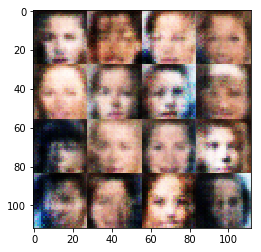

Epoch 1/1... Batch 621/3165... Discriminator Loss: 1.2955... Generator Loss: 0.9540
Epoch 1/1... Batch 641/3165... Discriminator Loss: 1.3482... Generator Loss: 0.9918
Epoch 1/1... Batch 661/3165... Discriminator Loss: 1.3838... Generator Loss: 1.0884
Epoch 1/1... Batch 681/3165... Discriminator Loss: 1.3455... Generator Loss: 1.0569
Epoch 1/1... Batch 701/3165... Discriminator Loss: 1.3085... Generator Loss: 1.2380
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


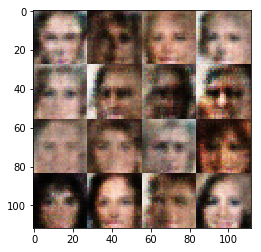

Epoch 1/1... Batch 721/3165... Discriminator Loss: 1.2938... Generator Loss: 1.0481
Epoch 1/1... Batch 741/3165... Discriminator Loss: 1.2408... Generator Loss: 1.2479
Epoch 1/1... Batch 761/3165... Discriminator Loss: 1.3689... Generator Loss: 1.0128
Epoch 1/1... Batch 781/3165... Discriminator Loss: 1.3164... Generator Loss: 0.9453
Epoch 1/1... Batch 801/3165... Discriminator Loss: 1.3351... Generator Loss: 0.9756
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


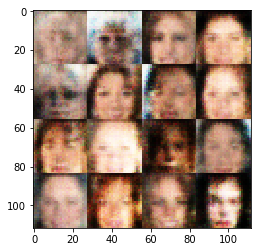

Epoch 1/1... Batch 821/3165... Discriminator Loss: 1.2847... Generator Loss: 1.0006
Epoch 1/1... Batch 841/3165... Discriminator Loss: 1.2940... Generator Loss: 1.0204
Epoch 1/1... Batch 861/3165... Discriminator Loss: 1.3940... Generator Loss: 1.0218
Epoch 1/1... Batch 881/3165... Discriminator Loss: 1.2844... Generator Loss: 1.0864
Epoch 1/1... Batch 901/3165... Discriminator Loss: 1.2536... Generator Loss: 1.1835
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


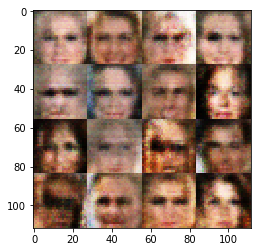

Epoch 1/1... Batch 921/3165... Discriminator Loss: 1.2719... Generator Loss: 1.0505
Epoch 1/1... Batch 941/3165... Discriminator Loss: 1.3697... Generator Loss: 0.9807
Epoch 1/1... Batch 961/3165... Discriminator Loss: 1.3617... Generator Loss: 1.0482
Epoch 1/1... Batch 981/3165... Discriminator Loss: 1.3137... Generator Loss: 1.0787
Epoch 1/1... Batch 1001/3165... Discriminator Loss: 1.3735... Generator Loss: 0.9737
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


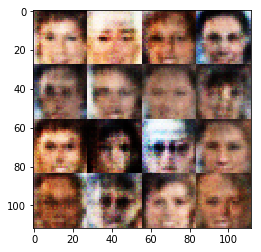

Epoch 1/1... Batch 1021/3165... Discriminator Loss: 1.3030... Generator Loss: 0.9629
Epoch 1/1... Batch 1041/3165... Discriminator Loss: 1.2867... Generator Loss: 1.1259
Epoch 1/1... Batch 1061/3165... Discriminator Loss: 1.2861... Generator Loss: 1.0288
Epoch 1/1... Batch 1081/3165... Discriminator Loss: 1.3023... Generator Loss: 1.1008
Epoch 1/1... Batch 1101/3165... Discriminator Loss: 1.3240... Generator Loss: 0.9211
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


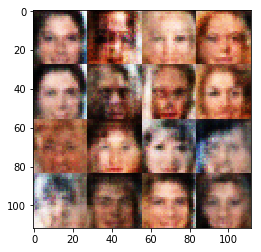

Epoch 1/1... Batch 1121/3165... Discriminator Loss: 1.3267... Generator Loss: 1.0457
Epoch 1/1... Batch 1141/3165... Discriminator Loss: 1.3292... Generator Loss: 0.9253
Epoch 1/1... Batch 1161/3165... Discriminator Loss: 1.3469... Generator Loss: 1.0062
Epoch 1/1... Batch 1181/3165... Discriminator Loss: 1.2875... Generator Loss: 1.0247
Epoch 1/1... Batch 1201/3165... Discriminator Loss: 1.3148... Generator Loss: 1.0999
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


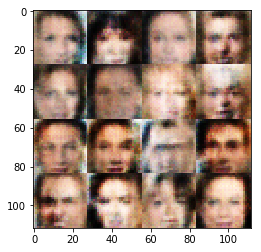

Epoch 1/1... Batch 1221/3165... Discriminator Loss: 1.3317... Generator Loss: 0.9762
Epoch 1/1... Batch 1241/3165... Discriminator Loss: 1.2923... Generator Loss: 1.0063
Epoch 1/1... Batch 1261/3165... Discriminator Loss: 1.3867... Generator Loss: 1.1507
Epoch 1/1... Batch 1281/3165... Discriminator Loss: 1.2917... Generator Loss: 1.1056
Epoch 1/1... Batch 1301/3165... Discriminator Loss: 1.3254... Generator Loss: 1.0786
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


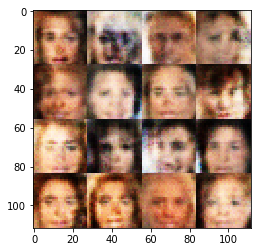

Epoch 1/1... Batch 1321/3165... Discriminator Loss: 1.3589... Generator Loss: 0.8318
Epoch 1/1... Batch 1341/3165... Discriminator Loss: 1.3587... Generator Loss: 0.9627
Epoch 1/1... Batch 1361/3165... Discriminator Loss: 1.3347... Generator Loss: 0.9752
Epoch 1/1... Batch 1381/3165... Discriminator Loss: 1.3559... Generator Loss: 0.9584
Epoch 1/1... Batch 1401/3165... Discriminator Loss: 1.3408... Generator Loss: 1.0433
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


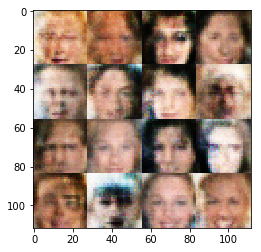

Epoch 1/1... Batch 1421/3165... Discriminator Loss: 1.2861... Generator Loss: 1.1007
Epoch 1/1... Batch 1441/3165... Discriminator Loss: 1.2995... Generator Loss: 0.9231
Epoch 1/1... Batch 1461/3165... Discriminator Loss: 1.2938... Generator Loss: 1.1476
Epoch 1/1... Batch 1481/3165... Discriminator Loss: 1.3054... Generator Loss: 1.0175
Epoch 1/1... Batch 1501/3165... Discriminator Loss: 1.3559... Generator Loss: 1.0444
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


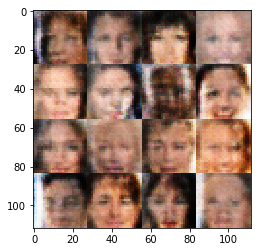

Epoch 1/1... Batch 1521/3165... Discriminator Loss: 1.2871... Generator Loss: 1.2044
Epoch 1/1... Batch 1541/3165... Discriminator Loss: 1.3357... Generator Loss: 1.0248
Epoch 1/1... Batch 1561/3165... Discriminator Loss: 1.2857... Generator Loss: 1.0306
Epoch 1/1... Batch 1581/3165... Discriminator Loss: 1.3262... Generator Loss: 0.9767
Epoch 1/1... Batch 1601/3165... Discriminator Loss: 1.3358... Generator Loss: 1.0332
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


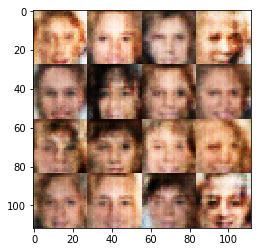

Epoch 1/1... Batch 1621/3165... Discriminator Loss: 1.3126... Generator Loss: 1.1173
Epoch 1/1... Batch 1641/3165... Discriminator Loss: 1.3404... Generator Loss: 1.0595
Epoch 1/1... Batch 1661/3165... Discriminator Loss: 1.3371... Generator Loss: 1.0122
Epoch 1/1... Batch 1681/3165... Discriminator Loss: 1.3154... Generator Loss: 0.9265
Epoch 1/1... Batch 1701/3165... Discriminator Loss: 1.3311... Generator Loss: 0.9710
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


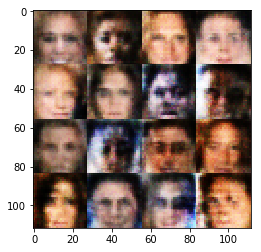

Epoch 1/1... Batch 1721/3165... Discriminator Loss: 1.3485... Generator Loss: 0.9713
Epoch 1/1... Batch 1741/3165... Discriminator Loss: 1.2945... Generator Loss: 1.0962
Epoch 1/1... Batch 1761/3165... Discriminator Loss: 1.3046... Generator Loss: 0.9505
Epoch 1/1... Batch 1781/3165... Discriminator Loss: 1.3752... Generator Loss: 0.8877
Epoch 1/1... Batch 1801/3165... Discriminator Loss: 1.3043... Generator Loss: 1.0414
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


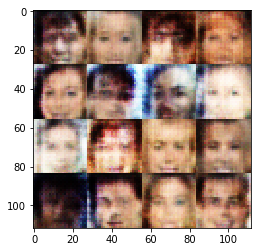

Epoch 1/1... Batch 1821/3165... Discriminator Loss: 1.3144... Generator Loss: 1.0045
Epoch 1/1... Batch 1841/3165... Discriminator Loss: 1.3133... Generator Loss: 1.0108
Epoch 1/1... Batch 1861/3165... Discriminator Loss: 1.3112... Generator Loss: 0.9889
Epoch 1/1... Batch 1881/3165... Discriminator Loss: 1.3232... Generator Loss: 0.9362
Epoch 1/1... Batch 1901/3165... Discriminator Loss: 1.3122... Generator Loss: 1.0541
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


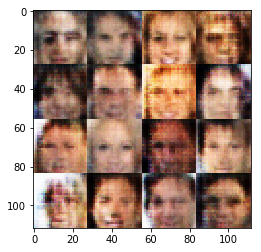

Epoch 1/1... Batch 1921/3165... Discriminator Loss: 1.3181... Generator Loss: 0.9015
Epoch 1/1... Batch 1941/3165... Discriminator Loss: 1.3350... Generator Loss: 0.9517
Epoch 1/1... Batch 1961/3165... Discriminator Loss: 1.3390... Generator Loss: 0.9659
Epoch 1/1... Batch 1981/3165... Discriminator Loss: 1.3209... Generator Loss: 0.9909
Epoch 1/1... Batch 2001/3165... Discriminator Loss: 1.3134... Generator Loss: 1.0649
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


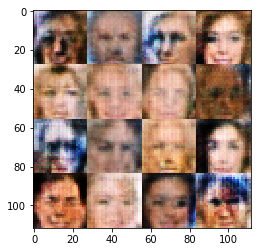

Epoch 1/1... Batch 2021/3165... Discriminator Loss: 1.3073... Generator Loss: 0.9702
Epoch 1/1... Batch 2041/3165... Discriminator Loss: 1.3173... Generator Loss: 1.0045
Epoch 1/1... Batch 2061/3165... Discriminator Loss: 1.2983... Generator Loss: 1.1185
Epoch 1/1... Batch 2081/3165... Discriminator Loss: 1.3601... Generator Loss: 0.9993
Epoch 1/1... Batch 2101/3165... Discriminator Loss: 1.3492... Generator Loss: 0.9026
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


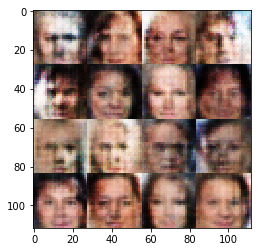

Epoch 1/1... Batch 2121/3165... Discriminator Loss: 1.3240... Generator Loss: 0.9743
Epoch 1/1... Batch 2141/3165... Discriminator Loss: 1.3188... Generator Loss: 0.9189
Epoch 1/1... Batch 2161/3165... Discriminator Loss: 1.3219... Generator Loss: 0.9945
Epoch 1/1... Batch 2181/3165... Discriminator Loss: 1.3182... Generator Loss: 0.9726
Epoch 1/1... Batch 2201/3165... Discriminator Loss: 1.3525... Generator Loss: 0.9561
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


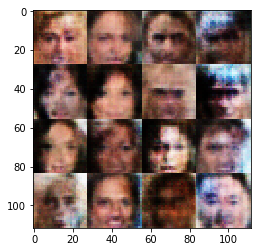

Epoch 1/1... Batch 2221/3165... Discriminator Loss: 1.3192... Generator Loss: 0.9675
Epoch 1/1... Batch 2241/3165... Discriminator Loss: 1.3234... Generator Loss: 0.9680
Epoch 1/1... Batch 2261/3165... Discriminator Loss: 1.3104... Generator Loss: 0.9446
Epoch 1/1... Batch 2281/3165... Discriminator Loss: 1.3159... Generator Loss: 1.0503
Epoch 1/1... Batch 2301/3165... Discriminator Loss: 1.3476... Generator Loss: 0.9936
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


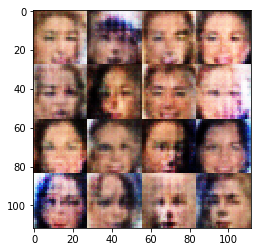

Epoch 1/1... Batch 2321/3165... Discriminator Loss: 1.3082... Generator Loss: 0.9345
Epoch 1/1... Batch 2341/3165... Discriminator Loss: 1.3493... Generator Loss: 1.0303
Epoch 1/1... Batch 2361/3165... Discriminator Loss: 1.3056... Generator Loss: 0.9813
Epoch 1/1... Batch 2381/3165... Discriminator Loss: 1.3257... Generator Loss: 0.9241
Epoch 1/1... Batch 2401/3165... Discriminator Loss: 1.3118... Generator Loss: 0.9710
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


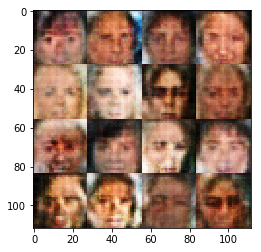

Epoch 1/1... Batch 2421/3165... Discriminator Loss: 1.3335... Generator Loss: 0.9576
Epoch 1/1... Batch 2441/3165... Discriminator Loss: 1.3067... Generator Loss: 0.9414
Epoch 1/1... Batch 2461/3165... Discriminator Loss: 1.3357... Generator Loss: 0.9749
Epoch 1/1... Batch 2481/3165... Discriminator Loss: 1.3393... Generator Loss: 1.0047
Epoch 1/1... Batch 2501/3165... Discriminator Loss: 1.3392... Generator Loss: 0.9127
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


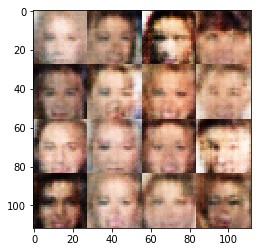

Epoch 1/1... Batch 2521/3165... Discriminator Loss: 1.3341... Generator Loss: 0.9414
Epoch 1/1... Batch 2541/3165... Discriminator Loss: 1.3158... Generator Loss: 0.8771
Epoch 1/1... Batch 2561/3165... Discriminator Loss: 1.3438... Generator Loss: 0.9946
Epoch 1/1... Batch 2581/3165... Discriminator Loss: 1.3236... Generator Loss: 1.0200
Epoch 1/1... Batch 2601/3165... Discriminator Loss: 1.3028... Generator Loss: 0.9598
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


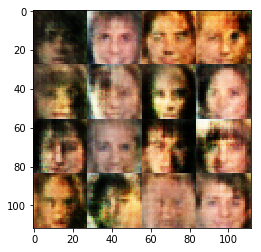

Epoch 1/1... Batch 2621/3165... Discriminator Loss: 1.3398... Generator Loss: 0.8204
Epoch 1/1... Batch 2641/3165... Discriminator Loss: 1.2874... Generator Loss: 0.9943
Epoch 1/1... Batch 2661/3165... Discriminator Loss: 1.3352... Generator Loss: 0.9814
Epoch 1/1... Batch 2681/3165... Discriminator Loss: 1.3430... Generator Loss: 1.0301
Epoch 1/1... Batch 2701/3165... Discriminator Loss: 1.3121... Generator Loss: 0.9574
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


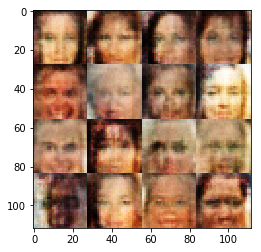

Epoch 1/1... Batch 2721/3165... Discriminator Loss: 1.3098... Generator Loss: 1.0152
Epoch 1/1... Batch 2741/3165... Discriminator Loss: 1.3207... Generator Loss: 0.9026
Epoch 1/1... Batch 2761/3165... Discriminator Loss: 1.2916... Generator Loss: 1.0334
Epoch 1/1... Batch 2781/3165... Discriminator Loss: 1.3487... Generator Loss: 0.9376
Epoch 1/1... Batch 2801/3165... Discriminator Loss: 1.3356... Generator Loss: 1.0867
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


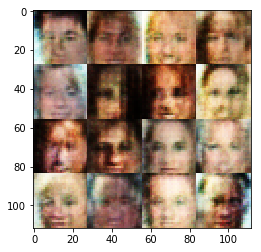

Epoch 1/1... Batch 2821/3165... Discriminator Loss: 1.3567... Generator Loss: 0.9631
Epoch 1/1... Batch 2841/3165... Discriminator Loss: 1.3327... Generator Loss: 0.9684
Epoch 1/1... Batch 2861/3165... Discriminator Loss: 1.3240... Generator Loss: 0.8829
Epoch 1/1... Batch 2881/3165... Discriminator Loss: 1.3641... Generator Loss: 1.0830
Epoch 1/1... Batch 2901/3165... Discriminator Loss: 1.3204... Generator Loss: 0.8848
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


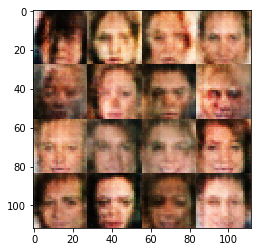

Epoch 1/1... Batch 2921/3165... Discriminator Loss: 1.3163... Generator Loss: 0.9603
Epoch 1/1... Batch 2941/3165... Discriminator Loss: 1.3218... Generator Loss: 0.9851
Epoch 1/1... Batch 2961/3165... Discriminator Loss: 1.3266... Generator Loss: 0.9611
Epoch 1/1... Batch 2981/3165... Discriminator Loss: 1.3260... Generator Loss: 1.0151
Epoch 1/1... Batch 3001/3165... Discriminator Loss: 1.3425... Generator Loss: 0.9146
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


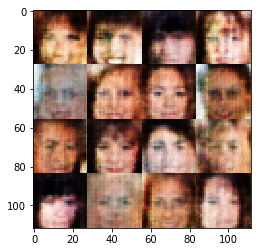

Epoch 1/1... Batch 3021/3165... Discriminator Loss: 1.3447... Generator Loss: 0.9356
Epoch 1/1... Batch 3041/3165... Discriminator Loss: 1.3297... Generator Loss: 0.9364
Epoch 1/1... Batch 3061/3165... Discriminator Loss: 1.3323... Generator Loss: 0.9509
Epoch 1/1... Batch 3081/3165... Discriminator Loss: 1.3220... Generator Loss: 0.9250
Epoch 1/1... Batch 3101/3165... Discriminator Loss: 1.3096... Generator Loss: 0.8964
G_in.shape: (?, 100)
G_x1.shape: (?, 7, 7, 256)
G_x2.shape: (?, 7, 7, 128)
G_x3.shape: (?, 14, 14, 64)
G_out.shape: (?, 28, 28, 3)


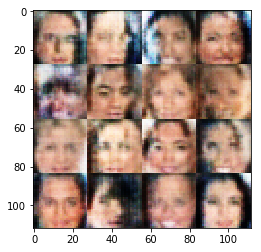

Epoch 1/1... Batch 3121/3165... Discriminator Loss: 1.3454... Generator Loss: 1.0088
Epoch 1/1... Batch 3141/3165... Discriminator Loss: 1.3049... Generator Loss: 1.0776
Epoch 1/1... Batch 3161/3165... Discriminator Loss: 1.3433... Generator Loss: 0.9985


In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.